In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lsst.afw.image as afwImage
from lsst.daf.butler import Butler, CollectionType
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
from astropy.table import Table
from lsst.source.injection.utils import ingest_injection_catalog
import pDIA as pdia
import importlib as imp
imp.reload(pdia)

from sklearn import metrics

from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky

from collections import deque

## Analyze a larger dataset (26 images)

In [228]:
from collections import deque

def generate_random_rc(max_r, max_c, n, random_state=0):
    # generate random positions
    # row id is between 0 and max_r
    # column id is between 0 and max_c
    np.random.seed(random_state)
    # generate random row index and column index
    random_r = np.random.randint(0, max_r, size=n)
    random_c = np.random.randint(0, max_c, size=n)
    random_rc = list(zip(random_r, random_c))
    return random_rc

def valid_rc(r, c, max_r, max_c):
    # This function check whether the row index and column index are valid
    if 0 <= r <= max_r and 0 <= c <= max_c:
        return True
    else:
        return False

def get_nearest_distance_to_sensor_edge(r, c, sensor_edge):
    """
    This funciton measure the nearest distance of a point to the sensor edge.
    The algorithm starts with a given point, then it grows a sqaure from the given point.
    In each iteration, the grow the half width of the square by one pixel.
    The iteration stops when the boundary of the square reach the sensor edge.
    The distance is the total number of iteration - 1.
    Example:
                                   x x x x x  
                        x x x      x x x x x 
    square       x  ->  x x x  ->  x x x x x
                        x x x      x x x x x  
                                   x x x x x 
    distance     0        1            2       
    
    Parameters:
    r: row index
    c: column index
    """
    
    sensor_edge = sensor_edge.copy()
    sensor_edge = sensor_edge.astype(int)
    max_r, max_c = sensor_edge.shape[0]-1, sensor_edge.shape[1]-1
    # delta indexes to the neighboring points
    delta_step = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    # create a queue to store the results
    queue = deque([(r, c)])
    # memorize visited points
    added = {(r, c)}
    # initialize the distance
    distance = -1
    # use breadth first search method
    while len(queue) > 0:
        distance += 1
        length = len(queue)
        for i in range(length):
            # pop out the points from the current boundary
            cur_r, cur_c = queue.popleft()
            if sensor_edge[cur_r][cur_c] == 1:
                return distance
            for delta in delta_step:
                dr, dc = delta[0], delta[1]
                next_r, next_c = cur_r + dr, cur_c + dc
                if valid_rc(next_r, next_c, max_r, max_c) and (next_r, next_c) not in added:
                    queue.append((next_r, next_c))
                    added.add((next_r, next_c))
    return distance

In [6]:
science_id_df = pd.read_csv('./data/piecewise_dia/table/science_ids_4638_fully_covered.csv')
data_dir = './data/piecewise_dia/'
# index=2 should be drop because its diaSrc table is not contiguous
science_id_df = science_id_df.drop(index=[2]).reset_index(drop=True)

In [7]:
len(science_id_df)

26

In [8]:
"""
artifact_distance = []
random_distance = []

for idx, row in science_id_df.iterrows():
    data_id, data_id_string = get_data_id_from_row(row)
    diaSrc = pd.read_csv(f'./data/piecewise_dia/difference/no_injection_default/diaSrc_{data_id_string}.csv')
    nonsat = pdia.remove_src_with_flags(diaSrc, flag_list=pdia.SAT_FLAGS)
    template = afwImage.ExposureF(f'./data/piecewise_dia/template/template_{data_id_string}.fits')
    wcs = template.getWcs()
    bbox = template.getBBox()
    template_mask = pdia.translateMask(template.getMask())
    sensor_edge = template_mask['SENSOR_EDGE'].copy()
    sensor_edge = sensor_edge.astype(int)   
    
    for i, source in nonsat.iterrows():
        pixel_x, pixel_y = source['base_NaiveCentroid_x'], source['base_NaiveCentroid_y']
        r, c = int(pixel_y - begin_y), int(pixel_x - begin_x)
        distance = get_nearest_distance_to_sensor_edge(r, c, sensor_edge)
        artifact_distance.append(distance) 
        
    max_r = sensor_edge.shape[0] - 1
    max_c = sensor_edge.shape[1] - 1
    random_rc = generate_random_rc(max_r, max_c, len(nonsat), 0)
    for i, rc in enumerate(random_rc):
        r, c = rc[0], rc[1]
        distance = get_nearest_distance_to_sensor_edge(r, c, sensor_edge)
        random_distance.append(distance)
        
artifact_distance = np.array(artifact_distance)
random_distance = np.array(random_distance)
pd.DataFrame({'artifact_distance': artifact_distance, 'random_distance': random_distance}).to_csv('distance_to_sensor_edge.csv', index=False)
""";

In [9]:
distance_to_sensor_edge = pd.read_csv('distance_to_sensor_edge.csv')

In [10]:
from scipy import stats
# two-sample Kolmogorov-Smirnov test
alpha = 0.05
statistic, p_value = stats.ks_2samp(distance_to_sensor_edge.artifact_distance, distance_to_sensor_edge.random_distance)

print('p value is %.3f' % p_value)
print('From the same distribution: %s' %str(p_value > alpha))

p value is 0.718
From the same distribution: True


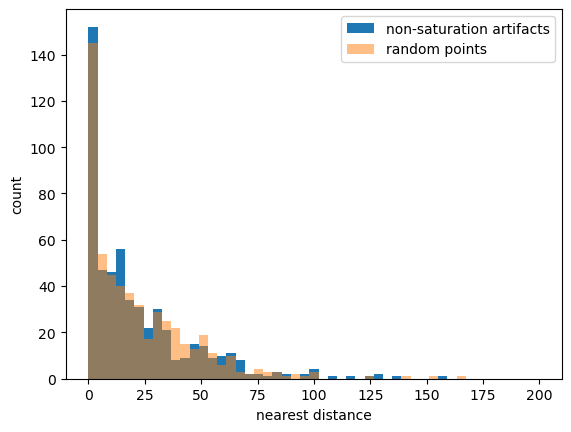

In [14]:
bins = np.linspace(0, 200, 50)
plt.hist(distance_to_sensor_edge.artifact_distance, bins=bins, label='non-saturation artifacts')
plt.hist(distance_to_sensor_edge.random_distance, bins=bins, alpha=0.5, label='random points')
plt.xlabel('nearest distance')
plt.ylabel('count')
plt.legend()